##### Publication trends forecasting outputs

* Train+val+test Data covers ~1960-2019.
    * Model/features optimized over 1980-2010

* Prediction 5 years (inclusive) in advance

* Temporal split over data


* `y_raw` = Actual amount of publications (normalized out of total pubs that year in pubmed)
* `preds` = model predictions

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline 

from sklearn.model_selection import cross_val_predict,TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor 
import numpy as np

In [2]:
def plot_var_preds(df,val:str="subthalamus"):
    df.loc[df["variable"].str.contains(val,case=False)][["y_raw","preds"]].plot(title=val) # "y_raw_predicted"

In [3]:
df_feat = pd.read_csv("trends_demo_rev22_predicted.tsv.gz",sep="\t",parse_dates=["Year","first","start"])

df_feat = df_feat.loc[df_feat["Year"]>= df_feat["start"]]
df_feat = df_feat.loc[(df_feat["Year"]>= df_feat["start"]) & (df_feat["year_num"]>= 1960) ].reset_index(drop=True)

df_feat.sort_values("Year",inplace=True,ascending=True) ## sort by year , not topic
df_feat["variable"] = df_feat["variable"].str.strip('"')

df = df_feat.filter(['Year', 'variable', 'y_raw',"preds",'y_raw_predicted',  'first', 'start', 'year_num',
               "pct_diff_lag6"],axis=1).set_index("Year").copy()

df.rename(columns={"y_raw_predicted":"preds"},inplace=True)
df

,variable,y_raw,preds,first,start,year_num
Year,,,,,,
1960-01-01 00:00:00+00:00,BLAST,10.693,14.983438,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,1960
1960-01-01 00:00:00+00:00,influenza,360.001,435.692230,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,1960
1960-01-01 00:00:00+00:00,lateral ventricles,10.693,12.378796,1946-01-01 00:00:00+00:00,1951-01-01 00:00:00+00:00,1960
1960-01-01 00:00:00+00:00,LSD,58.812,209.426529,1950-01-01 00:00:00+00:00,1955-01-01 00:00:00+00:00,1960
1960-01-01 00:00:00+00:00,lipid,2200.994,1960.983276,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,1960
...,...,...,...,...,...,...
2019-01-01 00:00:00+00:00,inflammatory,4105.101,3902.605713,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,2019
2019-01-01 00:00:00+00:00,RNA,4565.569,5554.289551,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,2019
2019-01-01 00:00:00+00:00,influenza,426.964,698.016235,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,2019


In [6]:
df["variable"].unique()

array(['BLAST', 'influenza', 'lateral ventricles', 'LSD', 'lipid',
       'lithium', 'Insular cortex', 'Histamine', 'zebra fish',
       'ultrasound', 'microglia', 'mouse', 'multiple sclerosis',
       'natural medicine', 'GABA', 'inflammatory', 'neocortex', 'opioids',
       'Epidemiology', 'paleocortex', 'pineal gland', 'EEG',
       'pituitary gland', 'thalamus', 'race', 'ribosome', 'rnase',
       'serotonin', 'single cell', 'Cingulate cortex', 'sleep',
       'neuropeptide', 'somatosensory cortex', 'Medulla oblongata',
       'vaccine', 'antibiotic resistance', 'aquaphonic agriculture',
       'archaea', 'autism', 'autoimmune', 'amygdala', 'basal ganglia',
       'vitamin C', 'cannabis', 'acetylcholine', 'vitamin D',
       'cerebellum', 'cholesterol', 'cocaine', 'hypothalamus', 'coral',
       'Prefrontal cortex', 'viral therapy', 'epinephrine',
       'ethnic differences', 'eugenics', 'Orbitofrontal cortex',
       'gene therapy', 'genetic engineering', 'Norepinephrine',
       

In [11]:
%%time 
tscv = TimeSeriesSplit(60)

def evaluate(model):
    """https://stats.stackexchange.com/questions/495151/cross-validation-for-time-series-what-am-i-doing-wrong"""
    # train model on training dataset
    i = 0
    for train_index, test_index in tscv.split(df_feat):
        i +=1
        if i%3==0: print(i)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        df_feat.loc[test_index,"preds"] =y_predict  ## ??

evaluate(model=clf)

display(df_feat[["year_num","y_raw","preds","y_raw_predicted","variable"]].dropna(axis=0))

print(df_feat[["year_num","y_raw","preds","y_raw_predicted"]].corrwith(df_feat["y_raw"]).round(3).sort_values())

1
2
3
4
6
7
8
9
11
12
13
14
16
17
18
19
21
22
23
24
26
27
28
29
31
32
33
34
36
37
38
39
41
42
43
44
46
47
48
49
51
52
53
54
56
57
58
59


,year_num,y_raw,preds,y_raw_predicted,variable
3635,1960,360.001,512.580469,435.692230,influenza
3792,1960,10.693,10.690682,12.378796,lateral ventricles
746,1960,58.812,19.957281,209.426529,LSD
3852,1960,2200.994,2980.050104,1960.983276,lipid
3912,1960,11.584,14.796734,32.926460,lithium
...,...,...,...,...,...
3634,2019,4105.101,5083.460075,3902.605713,inflammatory
1291,2019,4565.569,4989.696240,5554.289551,RNA
3694,2019,426.964,273.789735,698.016235,influenza
3494,2019,33.279,23.176260,132.785629,hydrophonics


year_num           0.108
preds              0.870
y_raw_predicted    0.987
y_raw              1.000
dtype: float64
CPU times: total: 14min 15s
Wall time: 3min 19s


In [12]:
df_feat.set_index("year_num",inplace=True)

In [13]:
df_feat["y_raw"].notna().sum()

6241

In [14]:
df_feat["preds"].notna().sum()

6120

### Plot Predictions


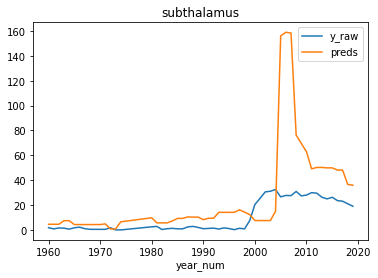

In [15]:
plot_var_preds(df_feat,"subthalamus")

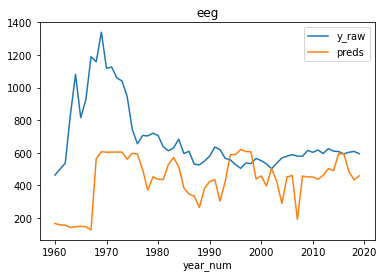

In [17]:
plot_var_preds(df_feat,"eeg")

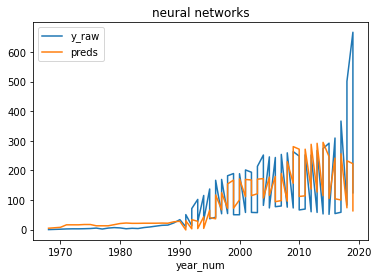

In [19]:
plot_var_preds(df_feat,"neural networks")

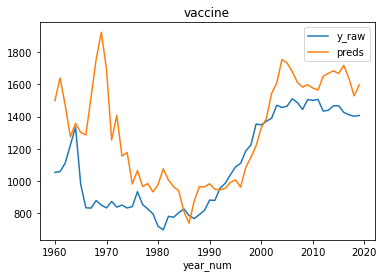

In [21]:
plot_var_preds(df_feat,"vaccine")

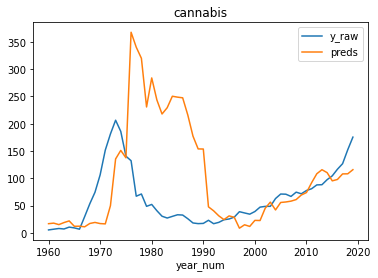

In [22]:
plot_var_preds(df_feat,"cannabis")

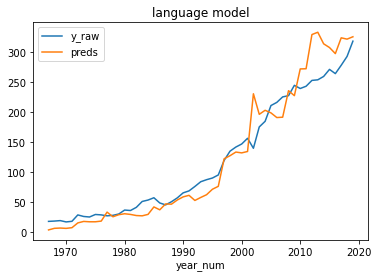

In [23]:
plot_var_preds(df_feat,"language model")

In [24]:
df.loc[df["start"].dt.year>1990]["variable"].unique()

array(['artificial neural networks', 'graph neural network', 'buckyballs',
       'carbon nanotubes', 'BRCA2', 'BRCA1', 'GWAS', 'illumina',
       'nanopore', 'metabolome', 'metagenomics', 'miRNA', 'CRISPR',
       'biosimilar', 'connectome', 'crispr cas-9'], dtype=object)

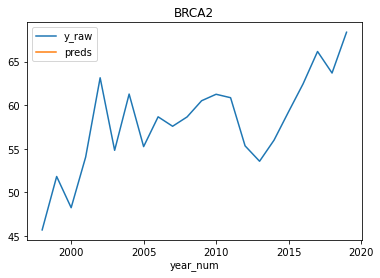

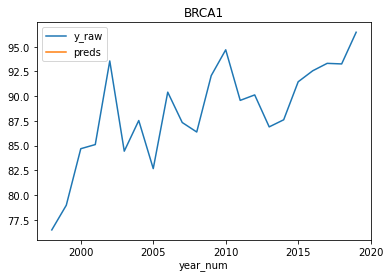

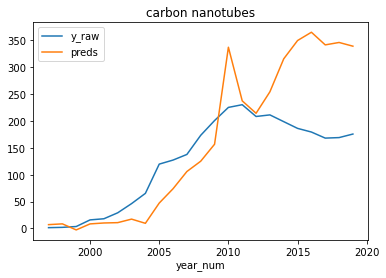

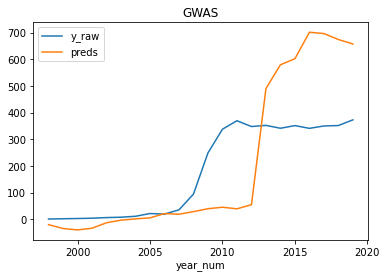

In [33]:
for i in ['BRCA2', 'BRCA1', 'carbon nanotubes', 'GWAS']:
    plot_var_preds(df_feat,i)

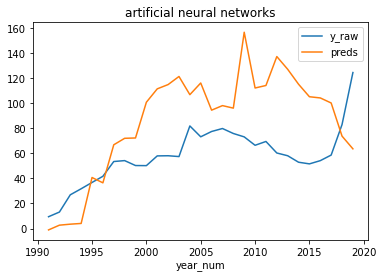

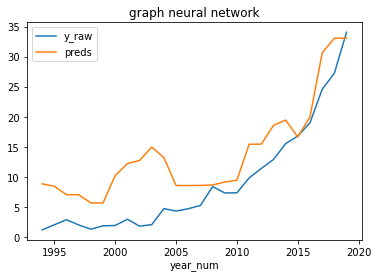

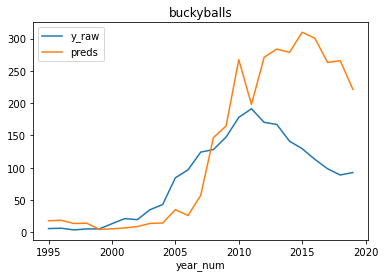

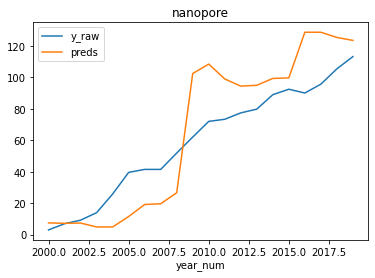

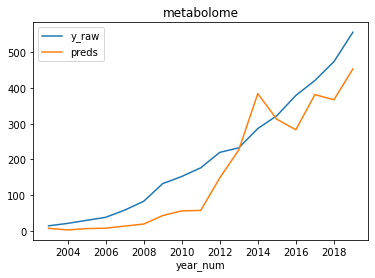

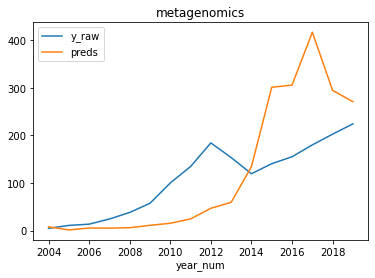

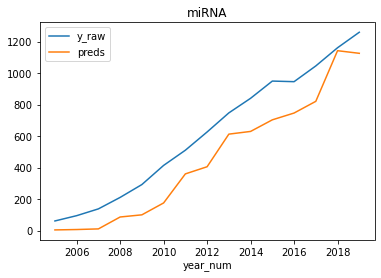

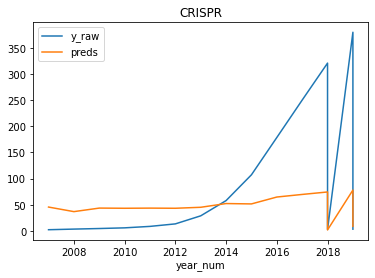

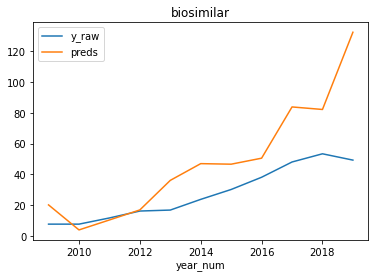

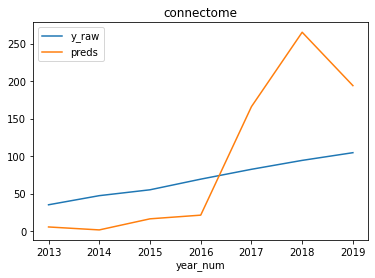

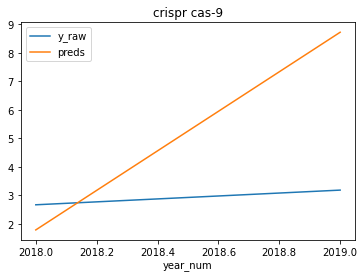

In [27]:
for i in ['artificial neural networks', 'graph neural network', 'buckyballs',
#        'carbon nanotubes', 'BRCA2', 'BRCA1', 'GWAS',
       'nanopore', 'metabolome', 'metagenomics', 'miRNA', 'CRISPR',
       'biosimilar', 'connectome', 'crispr cas-9',]:
    plot_var_preds(df_feat,i)

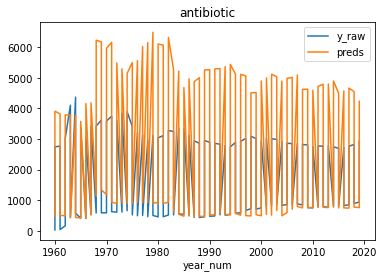

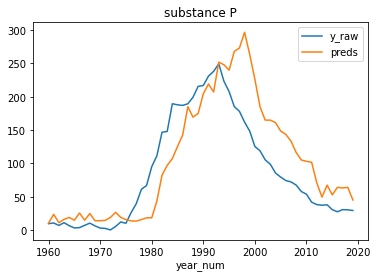

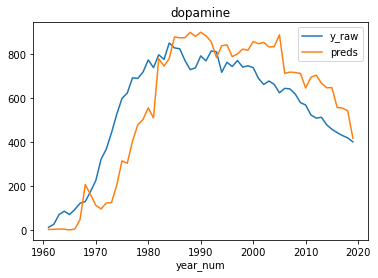

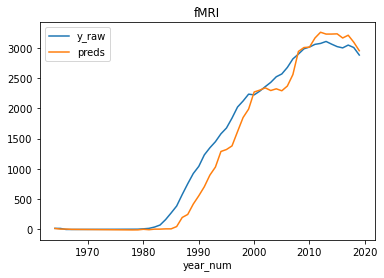

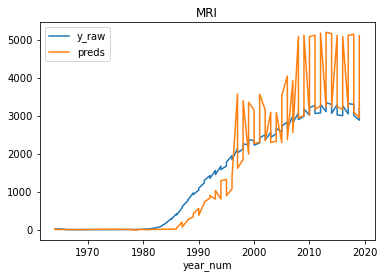

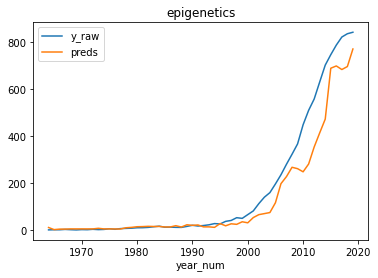

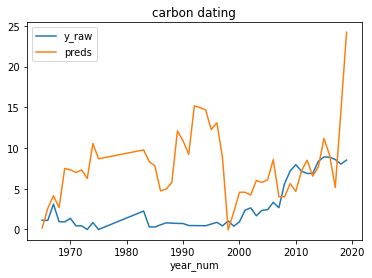

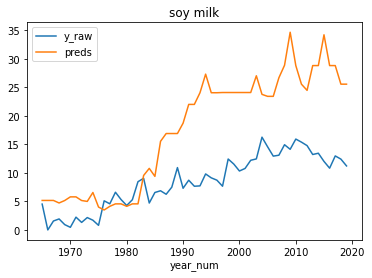

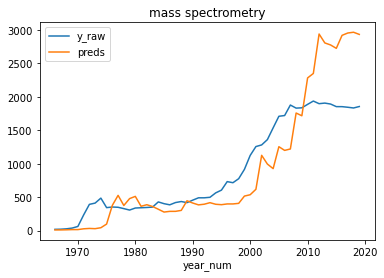

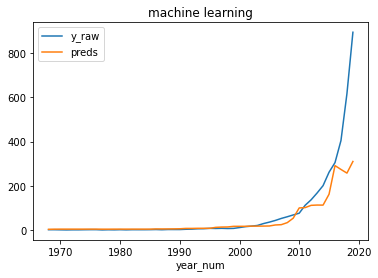

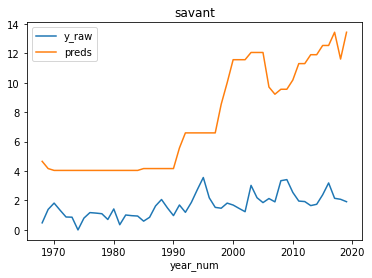

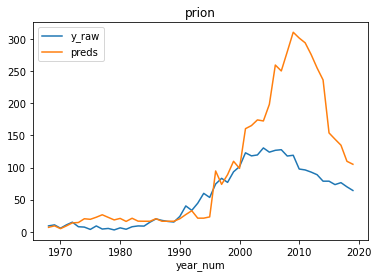

In [28]:
for i in ['antibiotic','substance P', 'dopamine', 'fMRI', 'MRI', 'epigenetics',
       'carbon dating', 'soy milk', 'mass spectrometry', 
       'machine learning', 'savant', 'prion']:
    plot_var_preds(df_feat,i)